In [1]:
# load libraries and scripts
using Plots
using FFTW
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/plotting.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");

In [2]:
# load borders
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [3]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);

  4.607772 seconds (3.77 M allocations: 16.983 GiB, 7.80% gc time, 8.24% compilation time)
  3.674571 seconds (4.27 M allocations: 1.250 GiB, 11.13% gc time, 62.87% compilation time)


In [4]:
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);
dm = load_discrete_model("../data/disc/pantagruel.h5", scale_factor);
th_disc = get_discrete_values(contmod.coord[contmod.isgrid,:], dm.coord, contmod.th[contmod.isgrid]);

[10000.0 7.328668622896828e-5]
[20000.0 2.2965261625040867e-5]
[30000.0 8.507341866637042e-6]
[40000.0 5.118063581832644e-6]
[50000.0 3.4487321686205163e-6]
[60000.0 2.4544407681847957e-6]
[70000.0 1.8232114173954983e-6]
[80000.0 1.4207582411662756e-6]
[90000.0 1.1641434587428279e-6]
[100000.0 1.0006808256468602e-6]
[110000.0 8.966633107121424e-7]
[120000.0 8.30526503348139e-7]
[130000.0 7.884990149698012e-7]
[140000.0 7.618021825583909e-7]
[150000.0 7.448478660521118e-7]
[160000.0 7.340823721113665e-7]
[170000.0 7.272472584141099e-7]
[180000.0 7.229078393677923e-7]
[190000.0 7.201529681477581e-7]
[200000.0 7.184040832219907e-7]
[210000.0 7.172938485400238e-7]
[220000.0 7.165890498761485e-7]
[230000.0 7.161416323286929e-7]
[240000.0 7.158576045274145e-7]
[250000.0 7.156773014216355e-7]
 29.512045 seconds (3.69 M allocations: 81.761 GiB, 5.88% gc time, 1.82% compilation time)


In [5]:
# Second model for fourier filtering
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-7);

  2.248979 seconds (529.80 k allocations: 16.811 GiB, 7.43% gc time)
  1.060900 seconds (3.87 k allocations: 1.011 GiB, 1.14% gc time)


In [6]:
# Get frequencies
freq = zeros(contmod2.Ny, contmod2.Nx)
freqx = fftfreq(contmod2.Nx, dx)
freqy = fftfreq(contmod2.Ny, dx)
for i=1:contmod2.Ny
    for j=1:contmod2.Nx
        freq[i, j] = sqrt(freqy[i]^2 + freqx[j]^2)
    end
end

In [7]:
# Create filter mask
filter = freq .<= .2 * maximum(freq);

In [8]:
# Filter m
mfft = fft(reshape(contmod2.m, contmod2.Ny, contmod2.Nx))
mfft[.!filter] .= 0.0
mifft = real.(ifft(mfft))
mifft[.!contmod2.isgrid] .= 0.0
contmod2.m = vec(mifft);

In [9]:
# Filter d
dfft = fft(reshape(contmod2.d, contmod2.Ny, contmod2.Nx))
dfft[.!filter] .= 0.0
difft = real.(ifft(dfft))
difft[.!contmod2.isgrid] .= 0.0
contmod2.d = vec(difft);

In [10]:
# Filter bx
bxfft = fft(reshape(contmod2.bx, contmod2.Ny, contmod2.Nx))
bxfft[.!filter] .= 0.0
bxifft = real.(ifft(bxfft))
bxifft[.!contmod2.isgrid] .= 0.0
contmod2.bx = vec(bxifft);

In [11]:
# Filter by
byfft = fft(reshape(contmod2.by, contmod2.Ny, contmod2.Nx))
byfft[.!filter] .= 0.0
byifft = real.(ifft(byfft))
byifft[.!contmod2.isgrid] .= 0.0
contmod2.by = vec(byifft);

In [12]:
# Filter p
ptemp = zeros(contmod2.Ny * contmod2.Nx)
ptemp[contmod2.isgrid] = contmod2.p
pfft = fft(reshape(ptemp, contmod2.Ny, contmod2.Nx))
pfft[.!filter] .= 0.0
pifft = real.(ifft(pfft))
pifft[.!contmod2.isgrid] .= 0.0
ptemp2 = vec(pifft)[contmod2.isgrid]
ptemp2 .-= sum(ptemp2) / sum(contmod2.isgrid)
contmod2.p = ptemp2;

In [13]:
# get stable solution for filtered model
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 9.047133777118077e-5]
[20000.0 3.071786739861082e-5]
[30000.0 1.5777491027546553e-5]
[40000.0 1.023205861017118e-5]
[50000.0 6.854149758872552e-6]
[60000.0 4.650271239858839e-6]
[70000.0 3.222931783009031e-6]
[80000.0 2.303863665842343e-6]
[90000.0 1.7144565989113403e-6]
[100000.0 1.337464633710539e-6]
[110000.0 1.096742155315411e-6]
[120000.0 9.431941943027766e-7]
[130000.0 8.453152211540527e-7]
[140000.0 7.829471817544231e-7]
[150000.0 7.432161694964634e-7]
[160000.0 7.179095959930493e-7]
[170000.0 7.017920666818611e-7]
[180000.0 6.915275108099195e-7]
[190000.0 6.849906710737486e-7]
[200000.0 6.808278574244042e-7]
[210000.0 6.781769119612591e-7]
[220000.0 6.764887572341394e-7]
[230000.0 6.754137271691718e-7]
[240000.0 6.747291392272814e-7]
[250000.0 6.742931890624249e-7]
 34.003194 seconds (2.26 M allocations: 81.680 GiB, 5.28% gc time)


In [14]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod.p
#println(size(contmod2.p))
hm_plot(contmod, temp, borders = [border], c = :inferno)
savefig("../figures/p_pre.svg")

temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod2.p
#println(size(contmod2.p))
hm_plot(contmod, temp, borders = [border], c = :inferno)
savefig("../figures/p_post.svg")

hm_plot(contmod, contmod.m, borders = [border], c = :inferno)
savefig("../figures/m_pre.svg")

hm_plot(contmod, contmod2.m, borders = [border], c = :inferno)
savefig("../figures/m_post.svg")

hm_plot(contmod, contmod.d, borders = [border], c = :inferno)
savefig("../figures/d_pre.svg")

hm_plot(contmod, contmod2.d, borders = [border], c = :inferno)
savefig("../figures/d_post.svg")

hm_plot(contmod, contmod.bx, borders = [border], c = :inferno)
savefig("../figures/bx_pre.svg")

hm_plot(contmod, contmod2.bx, borders = [border], c = :inferno)
savefig("../figures/bx_post.svg")

hm_plot(contmod, contmod.by, borders = [border], c = :inferno)
savefig("../figures/by_pre.svg")

hm_plot(contmod, contmod2.by, borders = [border], c = :inferno)
savefig("../figures/by_post.svg")

hm_plot(contmod, contmod.th, borders = [border], c = :inferno)
savefig("../figures/theta_pre.svg")

hm_plot(contmod, contmod2.th, borders = [border], c = :inferno)
savefig("../figures/theta_post.svg")


In [15]:
# create an horizontal color bar

vmin = min(minimum(contmod2.th), minimum(contmod2.th))
vmax = max(maximum(contmod2.th), maximum(contmod2.th))
x = collect(0:0.01:1)
x = collect(vmin:0.01:vmax)
n = length(x)
#nlabel = 7

#dv = vmax - vmin
#dtick = round(10 * dv / nlabel) / 10
#floor(vmin/dtick):dtick:floor(vmax/dtick)
#println(x)
#, tick_direction=:out
heatmap(x, [1], reshape(x,1,n), colorbar=false, yaxis=nothing, size=(400,50), xtick=-2:0.5:1.5)
savefig("../figures/colorbar.svg")

In [16]:
# performing a dynamical simulation on the reduced model

# Add perturbation around generator 1
# Run only ONCE as it directly changes the distribution of p!
add_local_disturbance!(contmod2, dm.coord[1,:], -9.0, 0.02, dx);

In [20]:
ts, thetas, omegas = perform_dyn_sim(contmod2, interval=2,
    Ndt=2500, dt=0.01, method="backward-euler");

Total time: 25.0
NIter: 20 Avg. Omega: -0.016356260867640863
NIter: 40 Avg. Omega: -0.03660880693140047
NIter: 60 Avg. Omega: -0.053516977920821086
NIter: 80 Avg. Omega: -0.06941829320751175
NIter: 100 Avg. Omega: -0.08536624789455995
NIter: 120 Avg. Omega: -0.09117208347921633
NIter: 140 Avg. Omega: -0.09021609787284623
NIter: 160 Avg. Omega: -0.08421081163637573
NIter: 180 Avg. Omega: -0.07980905542718998
NIter: 200 Avg. Omega: -0.07421484975729901
NIter: 220 Avg. Omega: -0.06679540466237334
NIter: 240 Avg. Omega: -0.06515575931022041
NIter: 260 Avg. Omega: -0.06603465991560797
NIter: 280 Avg. Omega: -0.06579916031333631
NIter: 300 Avg. Omega: -0.06660150483479715
NIter: 320 Avg. Omega: -0.07093819948240837
NIter: 340 Avg. Omega: -0.07718322179898465
NIter: 360 Avg. Omega: -0.08556300556036865
NIter: 380 Avg. Omega: -0.09728432067835178
NIter: 400 Avg. Omega: -0.10993025507559405
NIter: 420 Avg. Omega: -0.12088273849389042
NIter: 440 Avg. Omega: -0.1290477013478688
NIter: 460 Avg. Om

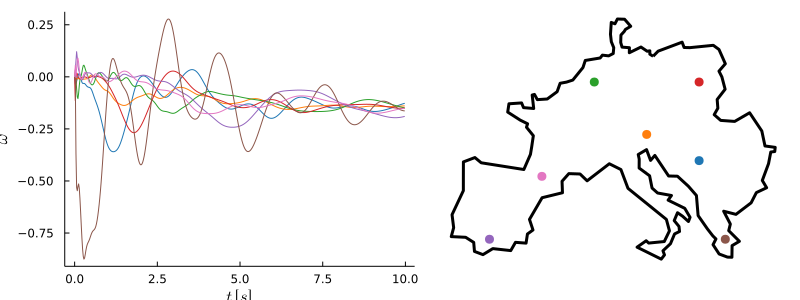

In [21]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
time_plot(contmod2, ts, omegas, c, borders = [border], tstart = 0.0, tend = 10.0)